# Attention is All You Need
* [paper](https://arxiv.org/abs/1706.03762)
* [annotated paper](http://nlp.seas.harvard.edu/annotated-transformer/#prelims) was very helpful for introduction to get familar some of the NLP specific stuff

In [ ]:
!pip install torchdata spacy
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

In [30]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

import matplotlib.pyplot as plt

import copy

In [31]:
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

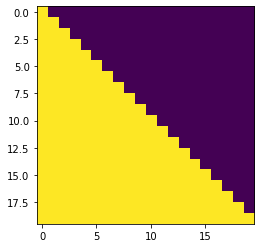

In [3]:
def subsequent_mask(d_model):
    attn_shape = (1, d_model, d_model)
    # annotated paper uses torch.triu and diagonal 1, but this should be equivalent
    mask = torch.tril(torch.ones(attn_shape), diagonal=0).type(torch.uint8)
    return mask == 1

# annotated paper also made display of mask overly complicated
mask = subsequent_mask(20)
plt.imshow(mask[0])

In [48]:
def scaled_dot_attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    scores = (d_k ** 0.5) * q @ k.transpose(-2, -1)
    if mask != None:
        scores = scores.masked_fill(mask == 0, -1e9)
    out = scores.softmax(dim=-1)
    if dropout:
        out = dropout(out)
    return out @ v, out

def get_heads(inp, w, bs, h, d_k):
    # (bs, seq_len, d_model) -> (bs, num_heads, seq_len, d_k)
    out = w(inp).view(bs, -1, h, d_k).transpose(1, 2)
    return out

def concat(inp, bs, h, d_k):
    # does being contiguous help with speed? if not, then why care? is dumb question?
    out = inp.transpose(1,2).contiguous().view(bs, -1, h*d_k)
    return out

class MultiHeadAttn(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, q, k, v, mask):
        if mask != None:
            mask = mask.unsqueeze(1)
        bs = q.size(0)

        # split into multi headed q, k, v
        q = get_heads(q, self.w_q, bs, self.h, self.d_k)
        k = get_heads(k, self.w_k, bs, self.h, self.d_k)
        v = get_heads(v, self.w_v, bs, self.h, self.d_k)

        attn, _ = scaled_dot_attention(q, k, v, mask, self.dropout)

        attn = concat(attn, bs, self.h, self.d_k)

        del q
        del k
        del v

        out = self.w_o(attn)

        return out

In [98]:
class EncoderLayer(nn.Module):
    def __init__(self, h, d_model, dropout=.1):
        super().__init__()
        self.d_model = d_model
        self.self_attn = MultiHeadAttn(h, d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.Dropout(.1),
            nn.Linear(d_model*4, d_model),
        )
        self.norm_1 = nn.LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.norm_2 = nn.LayerNorm(d_model)
        self.dropout_2 = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # apply self attn
        out = self.self_attn(x, x, x, mask)
        # apply normalize and dropout on residual conn
        out = self.norm_1(x + out)
        out_norm_1 = self.dropout_1(out)
        # apply feedforward
        out = self.ff(out_norm_1)
        # apply normalize and dropout on residual conn
        out = self.norm_2(out_norm_1 + out)
        out = self.dropout_2(out)
        return out

In [6]:
class Encoder(nn.Module):

    def __init__(self, h, d_model, N):
        super().__init__()
        self.enc_layer = EncoderLayer(h, d_model)
        self.enc_layers = nn.ModuleList([copy.deepcopy(self.enc_layer)] * N)
        # TODO: how big a difference?
        # self.enc_layers = [nn.EncoderLayer() for _ in range(N)]
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        out = x
        for layer in self.enc_layers:
            out = layer(x, mask)
        
        out = self.norm(out)

        return out

In [64]:
class DecoderLayer(nn.Module):
    def __init__(self, h, d_model, dropout=.1):
        super().__init__()
        self.d_model = d_model
        self.attn_1 = MultiHeadAttn(h, d_model)
        self.attn_2 = MultiHeadAttn(h, d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.Dropout(p=.1),
            nn.Linear(d_model*4, d_model),
        )
        self.norm_1 = nn.LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)

        self.norm_2 = nn.LayerNorm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

        self.norm_3 = nn.LayerNorm(d_model)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self, x, mem, src_mask, tgt_mask):
        
        out = self.attn_1(x, x, x, tgt_mask)
        # pretty sure annotated paper gets this backwards
        # also prob change name from mem (don't really think it conveys point very well)
        resid_1 = self.norm_1(x + self.dropout_1(out))
        out = self.attn_2(resid_1, mem, mem, src_mask)
        resid_2 = self.norm_2(resid_1 + self.dropout_2(out))
        out = self.ff(resid_2)
        resid_3 = self.norm_3(resid_2 + self.dropout_3(out))
        out = resid_3

        return out


In [72]:
class Decoder(nn.Module):
    def __init__(self, h, d_model, N):
        super().__init__()
        self.decode_layer = DecoderLayer(h, d_model)
        self.decode_layers = nn.ModuleList([copy.deepcopy(self.decode_layer)] * N)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mem, src_mask, tgt_mask):
        # print('x', x.shape)
        # print('mem', mem.shape)
        # print('src_mask', src_mask.shape)
        # print('tgt_mask', tgt_mask.shape)
        out = x
        for layer in self.decode_layers:
            out = layer(out, mem, src_mask, tgt_mask)
        
        out = self.norm(out)

        return out

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(1e4)) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div)
        self.pe[:, 1::2] = torch.cos(position * div)
        self.pe = self.pe.unsqueeze(0)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        out = x + self.pe[:, :x.size(1)].requires_grad_(False)
        # return out
        return self.dropout(out)

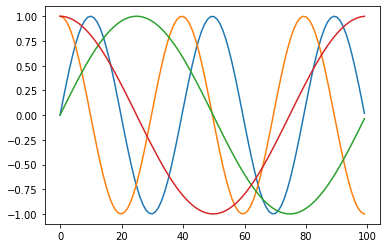

In [10]:
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(y[0, :, 4])
plt.plot(y[0, :, 5])
plt.plot(y[0, :, 6])
plt.plot(y[0, :, 7])

In [11]:
class Embedding(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * (self.d_model ** .5)

In [102]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, N=6, d_model=512, d_ff = 2048, h=8, dropout=.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = PositionalEncoding(d_model, dropout)
        self.src_emb = nn.Sequential(
            Embedding(d_model, src_vocab),
            copy.deepcopy(position),
        )
        self.tgt_emb = nn.Sequential(
            Embedding(d_model, tgt_vocab),
            copy.deepcopy(position),
        )
        self.encoder = Encoder(h, d_model, N)
        self.decoder = Decoder(h, d_model, N)
        self.generator = nn.Sequential(
            nn.Linear(d_model, tgt_vocab),
            nn.LogSoftmax(dim=-1),
        )

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt, src_mask, tgt_mask):
        mem = self.encode(src, src_mask)
        dec = self.decode(tgt, mem, src_mask, tgt_mask)
        return dec
        # out = self.generate(dec)
        # return out

    def encode(self, x, src_mask):
        return self.encoder(self.src_emb(x), src_mask)

    def decode(self, x, mem, src_mask, tgt_mask):
        return self.decoder(self.tgt_emb(x), mem, src_mask, tgt_mask)
    
    def generate(self, x):
        return self.generator(x)

In [86]:
def inference_test():
    # vocab size = 11 (numbers 0-10), stack size of 2 encoders and 2 decoders
    test_model = Transformer(11, 11, 2)
    test_model.eval()

    # seq len of 10
    src = torch.cuda.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    # identity mask
    src_mask = torch.ones(1,1,10)
    # encode the input phrase
    mem = test_model.encode(src, src_mask)
    
    # inital word in phrase
    ys = torch.zeros(1,1).type_as(src)

    for i in range(9):
        # run decoder using previous words in phrase and the encoded phrase
        # with tgt_mask that only selects words 
        out = test_model.decode(ys, mem, src_mask, subsequent_mask(ys.size(1)).type_as(src.data))
        # predict next work in phrase
        prob = test_model.generate(out[:, -1])
        print('prob.shape', prob.shape)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]

        # add predicted word to predictd phrase
        ys = torch.cat(
            [ys, torch.empty(1,1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("untrained model prediction:", ys)

# for _ in range(10):
inference_test()

prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
prob.shape torch.Size([1, 11])
untrained model prediction: tensor([[ 0, 10, 10, 10,  8,  8,  8,  2, 10,  6]])


In [109]:
class Batch:
    def __init__(self, src, tgt=None, pad=2):
        # 2 = <BLANK> token, so for masks ignore <BLANK> stokens
        self.src = src.cuda()
        self.src_mask = (src != pad).unsqueeze(-2).cuda()
        if tgt is not None:
            # ditch last word
            self.tgt = tgt[:, :-1].cuda()
            # grab everything shifted over one
            self.tgt_y = tgt[:,1:].cuda()

            self.tgt_mask = self.make_std_mask(self.tgt, pad).cuda()
            self.num_tokens = (self.tgt_y != pad).data.sum().cuda()

    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

In [16]:
class TrainState:
    step = 0 # steps taken current epoch
    accum_step = 0 # number of grad accum steps
    samples = 0 # examples used
    tokens = 0 # tokens processed

In [118]:
import time

def run_epoch(data_iter, model, loss_func, optim, scheduler, 
                    mode='train', accum_iter=1, train_state=TrainState()):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    num_accum = 0
    for i, batch in enumerate(data_iter):
        out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        loss, loss_node = loss_func(out, batch.tgt_y, batch.num_tokens)

        if mode == 'train' or mode == 'train+log':
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.num_tokens
            if i % accum_iter == 0:
                optim.step()
                optim.zero_grad()
                num_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        
        total_loss += loss
        total_tokens += batch.num_tokens
        tokens += batch.num_tokens

        if i % 40 == 1 and (mode == 'train' or mode == 'train+log'):
            lr = optim.param_groups[0]['lr']
            elapsed = time.time() - start
            print(f'Epohc Step: {i:6d} | Accumulation Step: {num_accum:3d} | Loss: {loss / batch.num_tokens:6.2f} | Tokens/s: {tokens/elapsed:7.1f} | Learning Rate: {lr:6.1e}')

In [18]:
def rate(step, d_model, factor, warmup):
    if step == 0:
        step = 1
    
    return factor * (d_model ** -.5 * min(step ** -.5, step * warmup ** -1.5))

In [89]:
# need to investigate this more later to better understand
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') # why sum? and not mean?
        self.padding_idx = padding_idx
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, tgt):
        assert x.size(1) == self.size

        true_dist = x.data.clone() # why clone just to fill with new values?
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, tgt.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(tgt.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill(0, mask.squeeze(), 0.)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [33]:
def data_gen(vocab, bs, num_batches):
    for i in range(num_batches):
        data = torch.randint(1, vocab, size=(bs, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

In [91]:
class SimpleLossCompute:
    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        # again, is contiguous here for performance gains? or am i dumb?
        criterion = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
        sloss = criterion / norm
        return sloss.data * norm, sloss

In [115]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    mem = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)

    for i in range(max_len - 1):
        out = model.decode(ys, mem, src_mask, subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.zeros(1,1).type_as(src.data).fill_(next_word)], dim=1)
   
    return ys

In [123]:
def simple_model():
    vocab_size = 11
    criterion = LabelSmoothing(size=vocab_size, padding_idx=0, smoothing=0.0).cuda()
    model = Transformer(vocab_size, vocab_size, N=2).cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(.9, .98), eps=1e-9)
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(step, d_model=model.src_emb[0].d_model, factor=1., warmup=400),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(data_gen(vocab_size, batch_size, 20), model, 
                  SimpleLossCompute(model.generator, criterion),
                  optimizer,
                  lr_scheduler,
                  mode='train')
        model.eval()
        run_epoch(data_gen(vocab_size, batch_size, 5), model, 
                  SimpleLossCompute(model.generator, criterion),
                  DummyOptimizer(),
                  DummyOptimizer(),
                  mode='eval')
    
    model.eval()
    src = torch.cuda.LongTensor([list(range(10))])
    max_len= src.shape[1]
    src_mask = torch.ones(1,1,max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))

# something be wrong. loss no go down 
# TODO: check loss func and label smoothing 
simple_model()


Epohc Step:      1 | Accumulation Step:   2 | Loss:   3.21 | Tokens/s: 14107.4 | Learning Rate: 5.5e-06
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.88 | Tokens/s: 23807.6 | Learning Rate: 6.1e-05
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.56 | Tokens/s: 24803.4 | Learning Rate: 1.2e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.34 | Tokens/s: 25861.7 | Learning Rate: 1.7e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.26 | Tokens/s: 25863.4 | Learning Rate: 2.3e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.18 | Tokens/s: 24147.6 | Learning Rate: 2.8e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.10 | Tokens/s: 25692.6 | Learning Rate: 3.4e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.06 | Tokens/s: 26064.6 | Learning Rate: 3.9e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.12 | Tokens/s: 24977.9 | Learning Rate: 4.5e-04
Epohc Step:      1 | Accumulation Step:   2 | Loss:   2.10 | Tok